## Import libraries and create deconv layer class

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Deconv2D(nn.Module):
    def __init__(self, shape=(2, 4)):
        super(Deconv2D, self).__init__()
        self.w_flat = nn.Parameter(data=torch.zeros(shape[0]*shape[1]-1),
                                   requires_grad=True)
        self.h_shape = shape

    def forward(self, x):
        w = nn.functional.pad(self.w_flat, (1, 0), value=1)

        w = torch.reshape(w, self.h_shape)
        hm1 = nn.functional.pad(w, (0, x.size(-1)-w.size(-1), 0, x.size(-2)-w.size(-2)))

        gm1f = 1/fft2(hm1)

        gm2f = torch.flip(gm1f, (0,))
        gm2f = torch.roll(gm1f, shifts=1, dims=0)

        gm3f = torch.flip(gm1f, (1,))
        gm3f = torch.roll(gm1f, shifts=1, dims=1)

        gm4f = torch.flip(gm1f, (0, 1))
        gm4f = torch.roll(gm1f, shifts=(1, 1), dims=(0,1))

        gmf = gm1f*gm2f*gm3f*gm4f

        ymf = gmf*fft2(x)

        y = ifft2(ymf).real

        return y

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


## Create Deconv NN

In [ ]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()

        self.deconv1 = Deconv2D((2, 2))
        self.deconv2 = Deconv2D((4, 4))
        self.deconv3 = Deconv2D((10, 10))

    
    def forward(self, x):
        # x = self.deconv1(x)
        # x = self.deconv2(x)
        x = self.deconv3(x)

        return x


## Create dataset class

In [ ]:
class BlurDataset(Dataset):
    def __init__(self, ds_path):
        self.ds_path = ds_path

        x_imgs = os.listdir(f'{ds_path}/blur')
        x_imgs.sort()

        y_imgs = os.listdir(f'{ds_path}/sharp')
        y_imgs.sort()

        self.x_paths = list(map(lambda img_path: f'{ds_path}/blur/{img_path}', x_imgs))
        self.y_paths = list(map(lambda img_path: f'{ds_path}/sharp/{img_path}', y_imgs))

        print(self.x_paths)
        print(self.y_paths)

    
    def __len__(self):
        return len(self.y_paths)


    def __getitem__(self, idx):
        x_path = self.x_paths[idx]
        y_path = self.y_paths[idx]

        x_img = io.read_image(x_path, io.ImageReadMode.GRAY)
        y_img = io.read_image(y_path, io.ImageReadMode.GRAY)

        SIZE = 1024
        PAD_SIZE = SIZE//2
        centre_crop = T.CenterCrop(SIZE)

        x_img = 

        # Preprocess images
        x_img = centre_crop(x_img)
        x_img = nn.functional.pad(x_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))
        x_img = x_img / 255.0
        

        y_img = centre_crop(y_img)
        y_img = nn.functional.pad(y_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))
        y_img = y_img / 255.0
        

        return x_img, y_img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/data/blur-dataset/'

Mounted at /content/drive


In [ ]:
'103_HUAWEI-P20_S.jpg'[:-5]

'103_HUAWEI-P20_'

In [ ]:
data = BlurDataset(ds_path=base_path)

data_len = len(data)
dataloader = DataLoader(data, batch_size=32, shuffle=True)

data_len

['/content/drive/MyDrive/data/blur-dataset//blur/0_IPHONE-SE_F.JPG', '/content/drive/MyDrive/data/blur-dataset//blur/100_NIKON-D3400-35MM_F.JPG', '/content/drive/MyDrive/data/blur-dataset//blur/101_NIKON-D3400-35MM_F.JPG', '/content/drive/MyDrive/data/blur-dataset//blur/102_NIKON-D3400-35MM_F.JPG', '/content/drive/MyDrive/data/blur-dataset//blur/103_HUAWEI-P20_F.jpg', '/content/drive/MyDrive/data/blur-dataset//blur/104_IPHONE-SE_F.jpg', '/content/drive/MyDrive/data/blur-dataset//blur/105_IPHONE-SE_F.jpg', '/content/drive/MyDrive/data/blur-dataset//blur/106_NIKON-D3400-35MM_F.JPG', '/content/drive/MyDrive/data/blur-dataset//blur/107_XIAOMI-MI8-SE_F.jpg', '/content/drive/MyDrive/data/blur-dataset//blur/108_XIAOMI-MI8-SE_F.jpg', '/content/drive/MyDrive/data/blur-dataset//blur/109_HONOR-7X_F.jpg', '/content/drive/MyDrive/data/blur-dataset//blur/10_ASUS-ZENFONE-LIVE-ZB501KL_F.jpg', '/content/drive/MyDrive/data/blur-dataset//blur/110_IPHONE-7_F.jpeg', '/content/drive/MyDrive/data/blur-datase

350

(-0.5, 2047.5, 2047.5, -0.5)

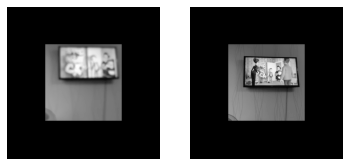

In [ ]:
blur_img, unblur_img = next(iter(dataloader))

plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(blur_img[0, 0, :, :],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(unblur_img[0, 0, :, :],cmap='gray')
plt.axis('off')

## Training function

In [ ]:
def train_model(model, criterion, optimizer, dataloader, num_epochs=1000):
    for epoch in range(num_epochs):
        model.train()
        running_loss= 0.0
        
        for X, y in tqdm(dataloader):

            X = X.to(device)
            y = y.to(device)

            with torch.set_grad_enabled(True):
                outputs = model(X)
                loss = criterion(outputs, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss

        if (epoch+1)%1 == 0:
            print('Epoch {:04d} loss: {:.4f}'.format(epoch+1, running_loss))

In [ ]:
model = DNN()

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
train_model(model, criterion, optimizer, dataloader, num_epochs=5)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0001 loss: 0.1745


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0002 loss: 0.1316


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0003 loss: 0.1292


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0004 loss: 0.1276


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0005 loss: 0.1260


In [ ]:
model.eval()
X, y = next(iter(dataloader))

X = X.to(device)
y = y.to(device)

y_pred = model(X)

X = X.to("cpu")
y = y.to("cpu")
y_pred = y_pred.to("cpu")

Text(0.5, 1.0, 'Original')

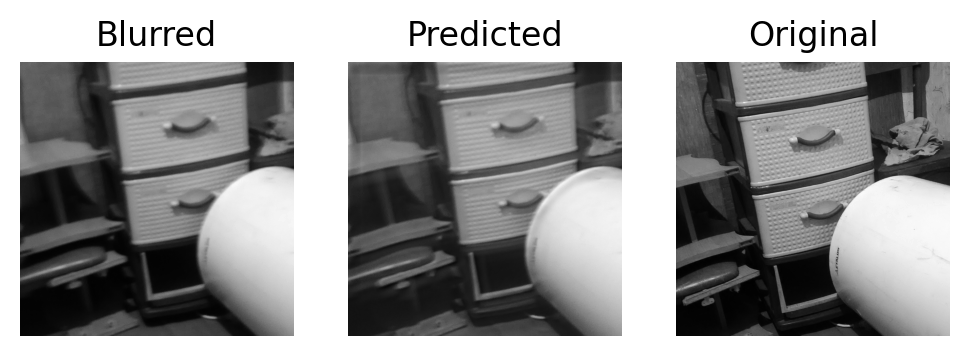

In [ ]:
import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1) // 4
end = start * 3

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,0,start:end,start:end], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,0,start:end,start:end].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,0,start:end,start:end], cmap='gray')
plt.axis('off')
plt.title('Original')

In [ ]:
model.deconv1.w_flat

Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)

In [ ]:
deconv1

NameError: ignored